In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


# custom functions
import sys
sys.path.append("/Users/java/Documents/10Acadamy/week - 3/Rossmann Pharmaceuticals")
from myscripts import util
from myscripts import plot

In [2]:
## Read Datas

store_file = '../data/store.csv'
test_file = '../data/test.csv'
train_file = '../data/train.csv'

In [3]:
store_df = pd.read_csv(store_file, parse_dates = True, low_memory = False)

In [28]:
train_df = pd.read_csv(train_file, parse_dates = True, low_memory = False)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = util.add_month_year(train_df)

/Users/java/Documents/10Acadamy/week - 3/Rossmann Pharmaceuticals/myscripts/util.py:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  new_df['WeekOfYear'] = df['Date'].dt.weekofyear


In [5]:
test_df = pd.read_csv(test_file, parse_dates = True, low_memory = False)

### Isolate the Rossmann Store Sales dataset into time series data

In [34]:
## check only Year 2014 of store = 1

sales_df = train_df[(train_df['Year'] == 2014) & (train_df['Store'] == 1)][['Date', 'Sales']].set_index('Date')
sales_df.head()

,Sales
Date,
2014-12-31,2605
2014-12-30,6466
2014-12-29,6463
2014-12-28,0
2014-12-27,6057


In [35]:
### Scale sales data
scaler = MinMaxScaler()
sales_df['SalesScaled'] = scaler.fit_transform(sales_df[['Sales']])

sales_df.head()

,Sales,SalesScaled
Date,,
2014-12-31,2605,0.279177
2014-12-30,6466,0.692959
2014-12-29,6463,0.692637
2014-12-28,0,0.000000
2014-12-27,6057,0.649127


In [36]:
## Descriptive Statistical Visualization
sales_df.describe()
sales_df.shape

(365, 2)

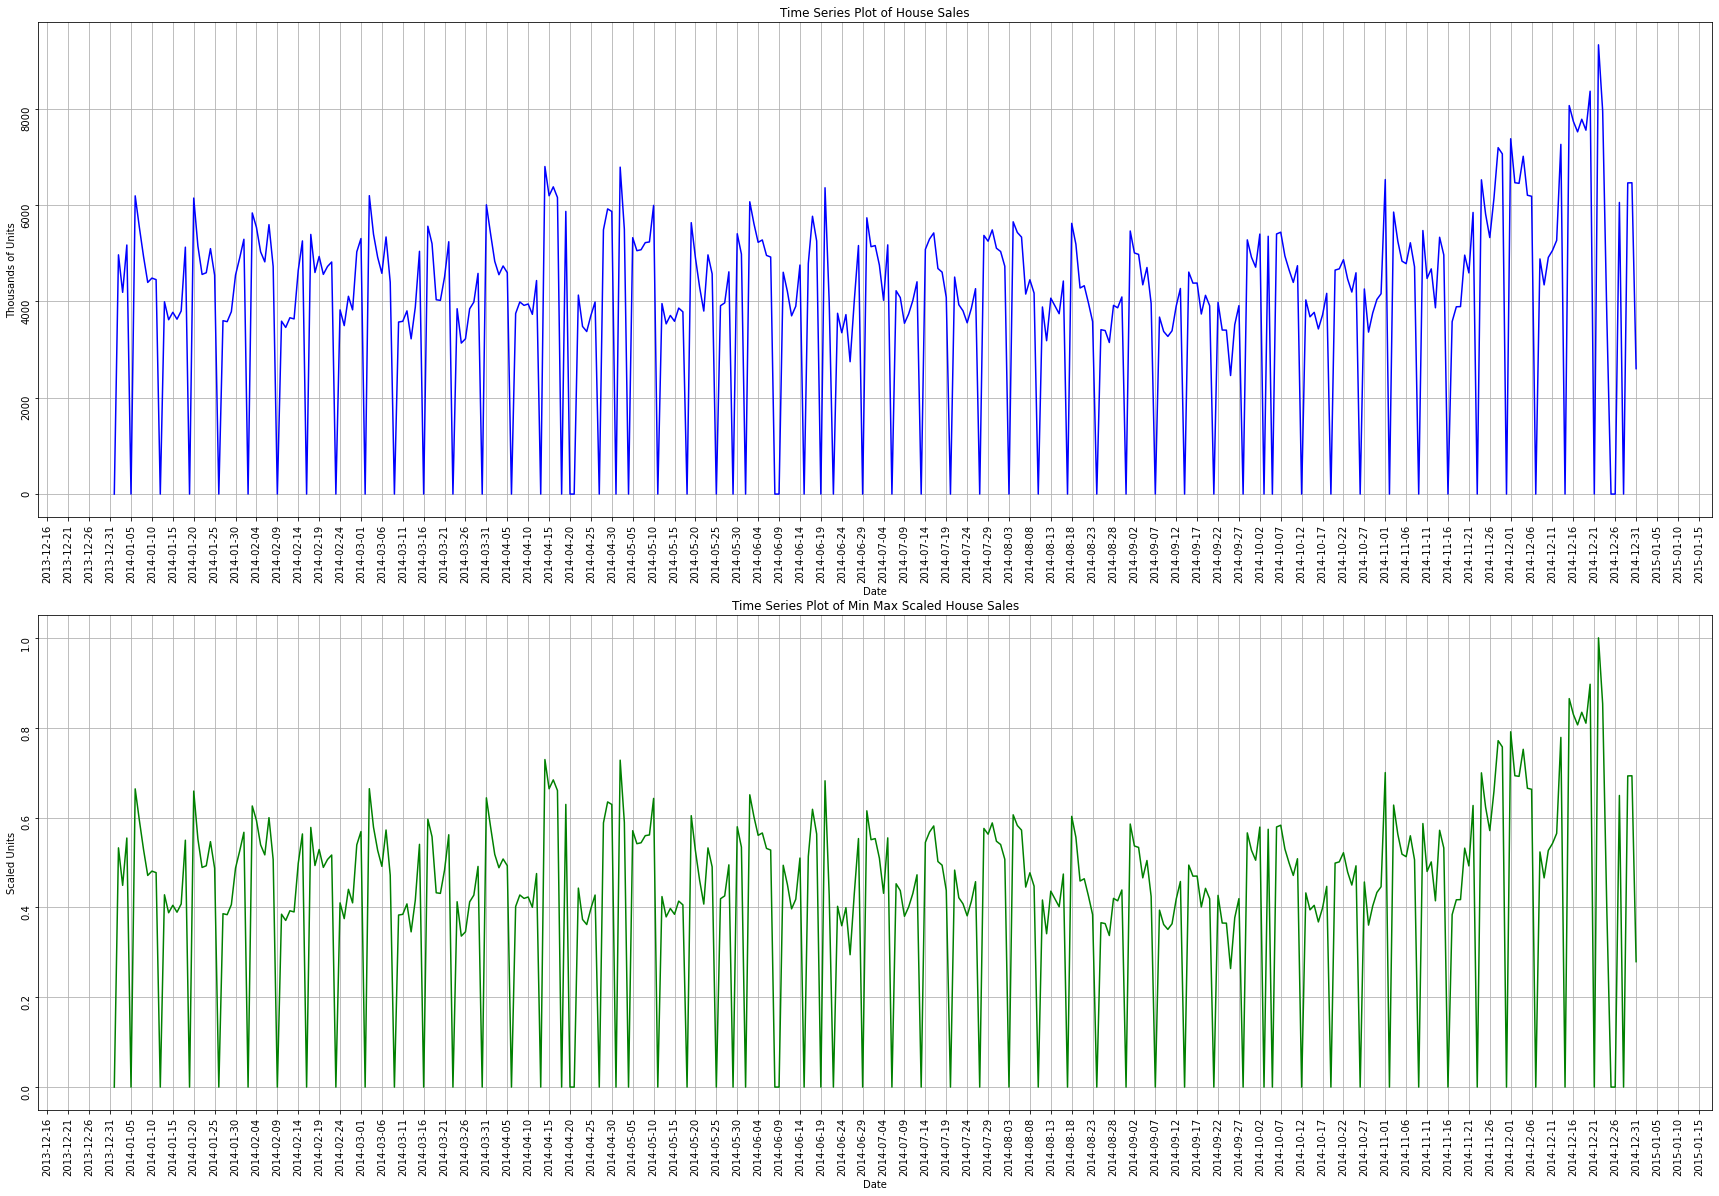

In [37]:
### Plot
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(sales_df.index, sales_df.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(sales_df.index, sales_df.SalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled House Sales')
ax2.grid(True)
plt.show()

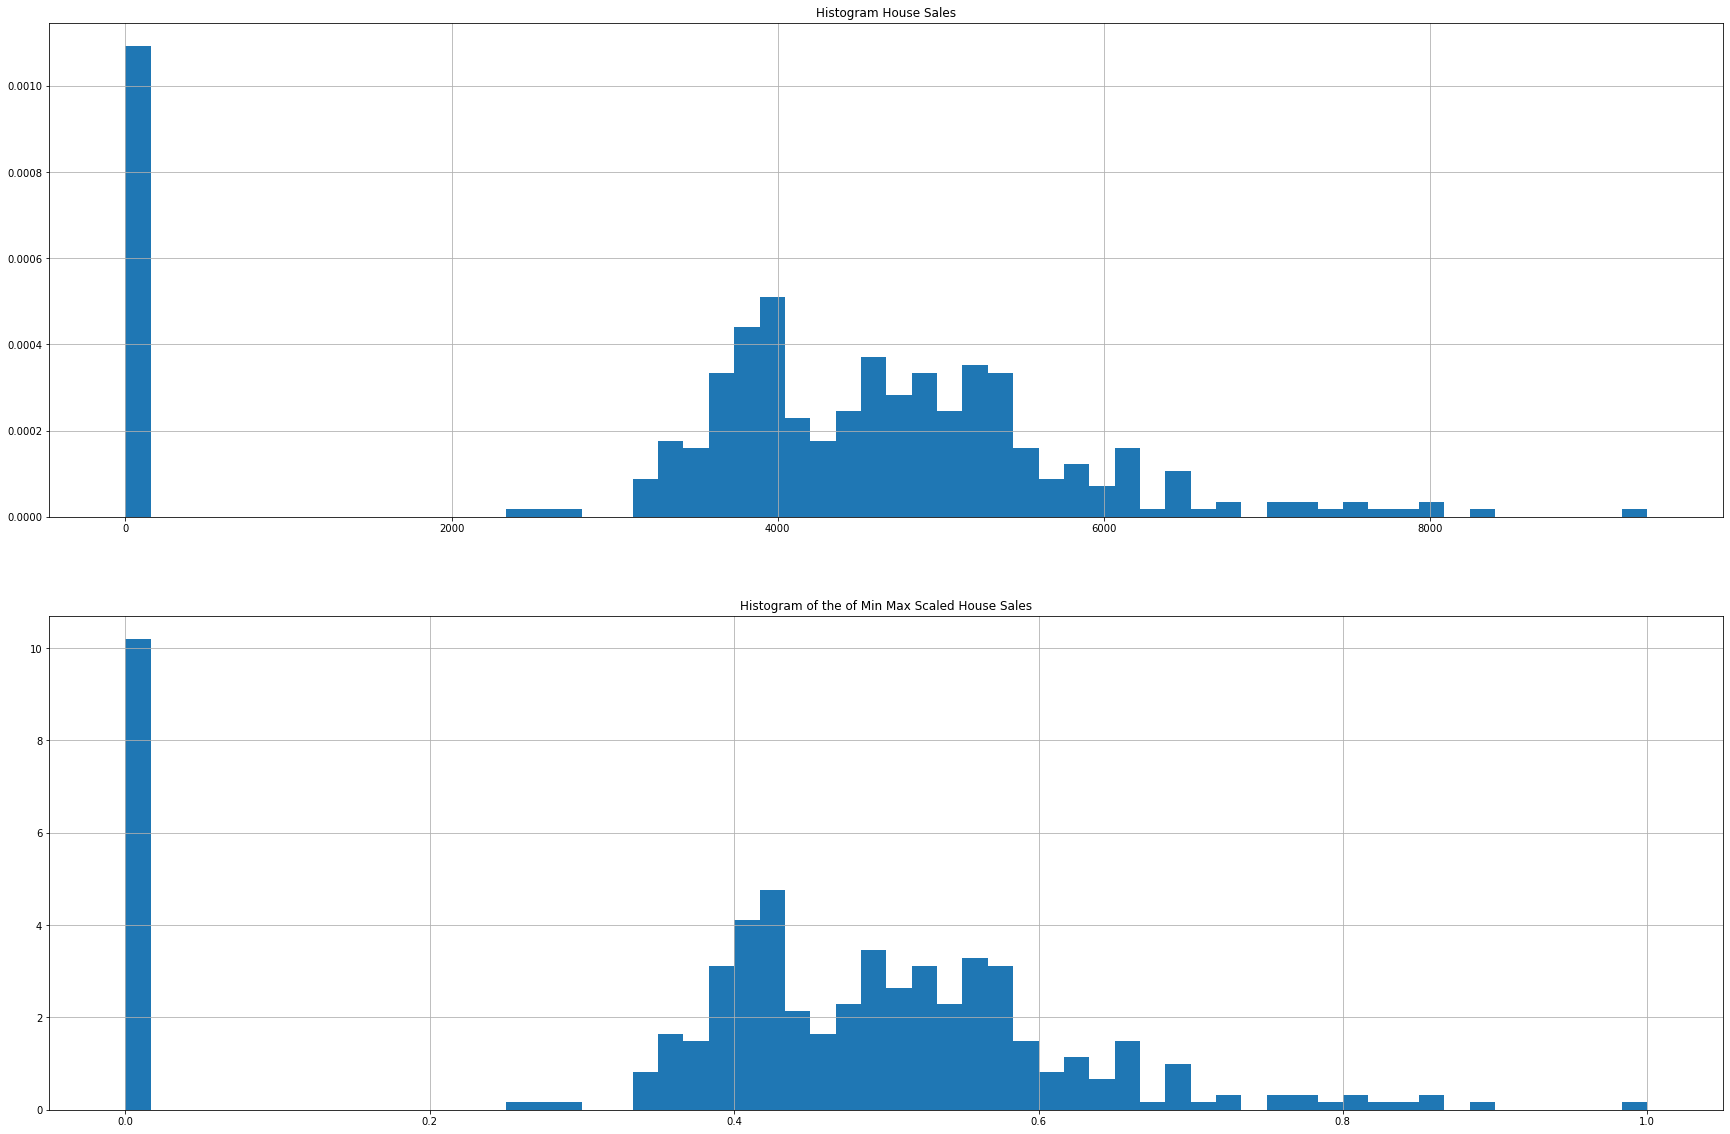

In [41]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(sales_df.Sales, density=True, bins=60)
ax1.title.set_text('Histogram House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(sales_df.SalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled House Sales')
ax2.grid(True)
plt.show()

### Check whether your time Series Data is Stationary

In [42]:
#Unit Root Tests helps us determine the stationarity of our data
adfResult = adfuller(sales_df.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -3.3465857126159753
p-value: 0.012920250161456601


In [43]:
adfResult = adfuller(sales_df.SalesScaled.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -3.3465857126160077
p-value: 0.012920250161455303


### Depending on your conclusion from 2 above difference your time series data 

In [44]:
## !!! What is the purpose ? 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

salesScaledDiff = difference(sales_df.SalesScaled.values)
salesScaledDiff

0      0.413782
1     -0.000322
2     -0.692637
3      0.649127
4     -0.649127
         ...   
359   -0.663809
360    0.554389
361   -0.105348
362    0.083485
363   -0.532526
Length: 364, dtype: float64

### Transform the time series data into supervised learning data by creating a new y(target) column. As illustrated here in the Sliding Window For Time Series Data section

In [45]:
acfSalesScaled = acf(sales_df.SalesScaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)


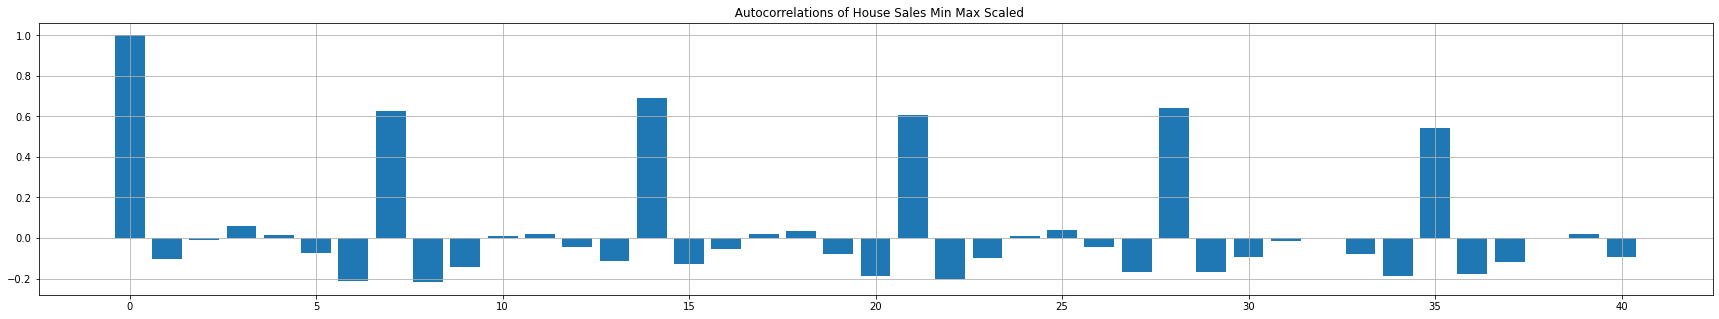

In [46]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of House Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()
corrPlots(acfSalesScaledNp, '')

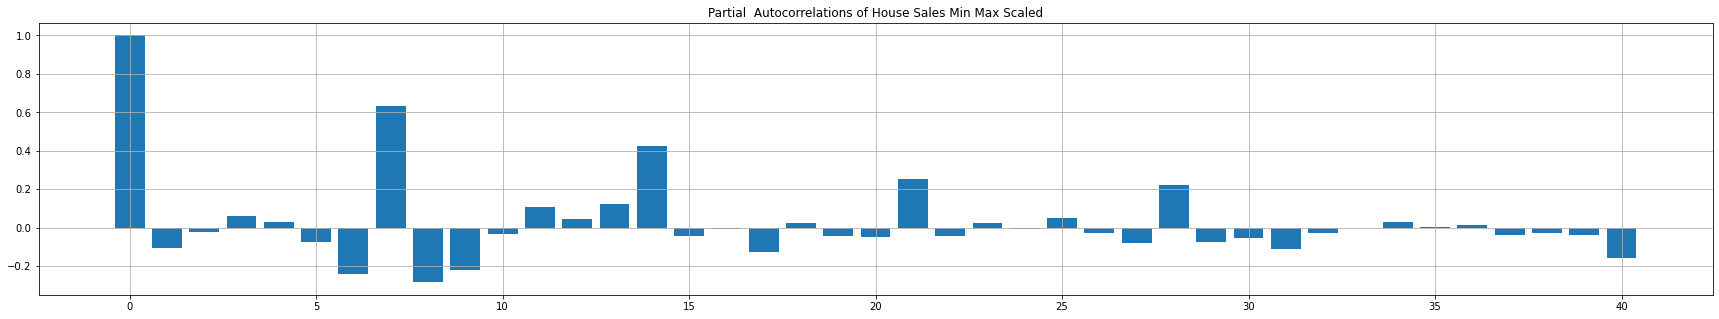

In [48]:
pacfSalesScaled = pacf(sales_df.SalesScaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)
corrPlots(pacfSalesScaledNp, "Partial")

In [49]:
SIZE = len(sales_df.SalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [50]:
DateTrain = sales_df.index.values[0:BATCH_SIZE]
DateValid = sales_df.index.values[BATCH_SIZE:]
XTrain = sales_df.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = sales_df.SalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (269, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (269,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [54]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([269, 1])

In [55]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset shapes: (1,), types: tf.float32>

In [56]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [58]:
# Example of Window
# datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
# datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
# for window in datasetEx:
#     print([elem.numpy() for elem in window])

In [59]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [60]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [62]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [67]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

### Define and Estimate the LSTM.

In [39]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 8)           320       
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: 0.0486 - val_loss: 0.0476
Epoch 2/200
1/1 [==============================] - 0s 150ms/step - loss: 0.0463 - val_loss: 0.0453
Epoch 3/200
1/1 [==============================] - 0s 187ms/step - loss: 0.0441 - val_loss: 0.0431
Epoch 4/200
1/1 [==============================] - 0s 151ms/step - loss: 0.0420 - val_loss: 0.0409
Epoch 5/200
1/1 [==============================] - 0s 165ms/step - loss: 0.0399 - val_loss: 0.0388
Epoch 6/200
1/1 [==============================] - 0s 168ms/step - loss: 0.0379 - val_loss: 0.0368
Epoch 7/200
1/1 [==============================] - 0s 154ms/step - loss: 0.0360 - val_loss: 0.0349
Epoch 8/200
1/1 [==============================] - 0s 152ms/step - loss: 0.0341 - val_loss: 0.0331
Epoch 9/200
1/1 [==============================] - 0s 145ms/step - loss: 0.0324 - val_loss: 0.0314
Epoch 10/200
1/1 [==============================] - 0s 147ms/step - loss: 0.0307 - val_loss: 0.0298
Epoch 11/200

1/1 [==============================] - 0s 161ms/step - loss: 0.0204 - val_loss: 0.0204
Epoch 84/200
1/1 [==============================] - 0s 164ms/step - loss: 0.0204 - val_loss: 0.0204
Epoch 85/200
1/1 [==============================] - 0s 161ms/step - loss: 0.0204 - val_loss: 0.0204
Epoch 86/200
1/1 [==============================] - 0s 166ms/step - loss: 0.0204 - val_loss: 0.0204
Epoch 87/200
1/1 [==============================] - 0s 154ms/step - loss: 0.0204 - val_loss: 0.0204
Epoch 88/200
1/1 [==============================] - 0s 176ms/step - loss: 0.0204 - val_loss: 0.0204
Epoch 89/200
1/1 [==============================] - 0s 189ms/step - loss: 0.0204 - val_loss: 0.0204
Epoch 90/200
1/1 [==============================] - 0s 154ms/step - loss: 0.0204 - val_loss: 0.0204
Epoch 91/200
1/1 [==============================] - 0s 153ms/step - loss: 0.0204 - val_loss: 0.0204
Epoch 92/200
1/1 [==============================] - 0s 152ms/step - loss: 0.0204 - val_loss: 0.0204
Epoch 93/200


1/1 [==============================] - 0s 159ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 165/200
1/1 [==============================] - 0s 166ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 166/200
1/1 [==============================] - 0s 155ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 167/200
1/1 [==============================] - 0s 163ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 168/200
1/1 [==============================] - 0s 156ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 169/200
1/1 [==============================] - 0s 167ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 170/200
1/1 [==============================] - 0s 157ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 171/200
1/1 [==============================] - 0s 155ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 172/200
1/1 [==============================] - 0s 166ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 173/200
1/1 [==============================] - 0s 164ms/step - loss: 0.0202 - val_loss: 0.0202
Epoc

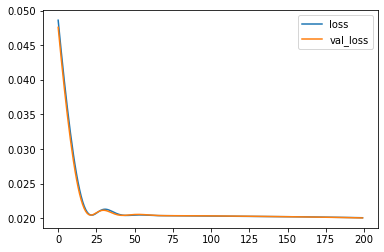

In [42]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [44]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True) 
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(SIZE).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [46]:
Forecast = model_forecast(model, sales_df.SalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

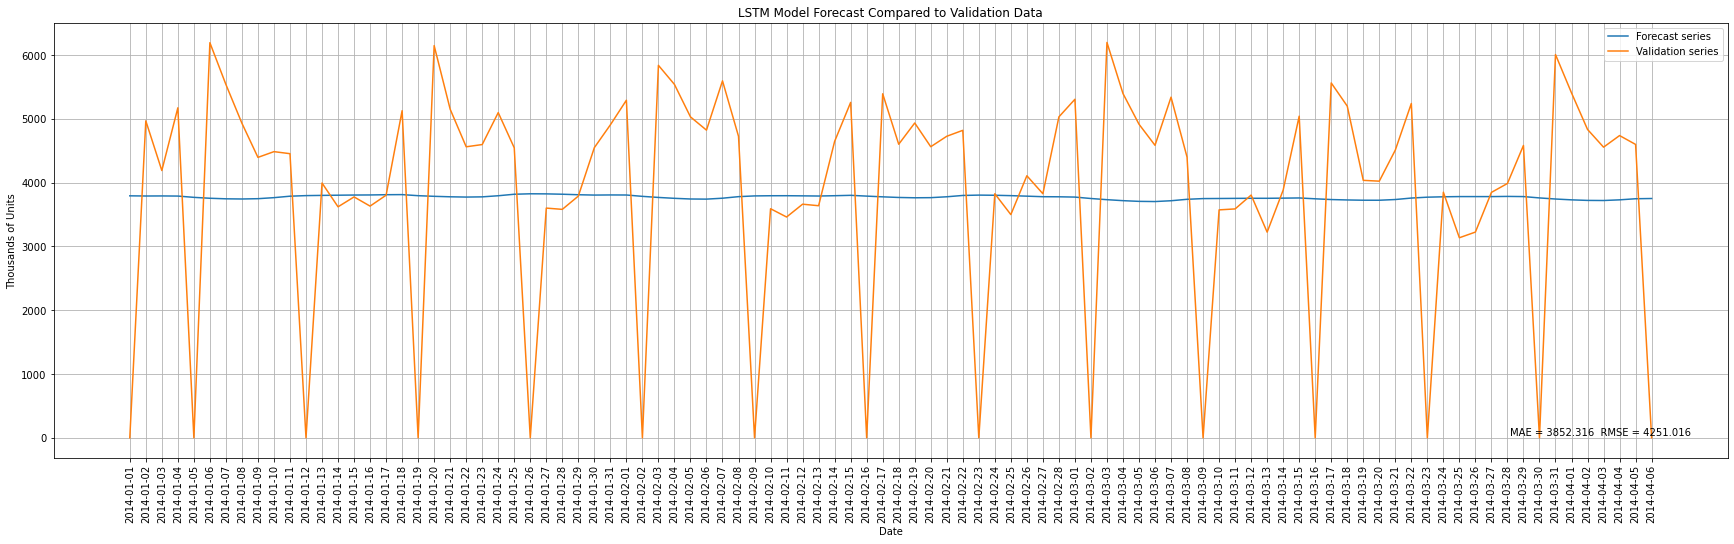

In [47]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [48]:
print(textstr)

MAE = 3852.316  RMSE = 4251.016
